In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font='SimHei')
plt.rcParams['axes.grid'] = False

from IPython.display import SVG

def show_image(filename, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)

    plt.imshow(plt.imread(filename))

GBDT(Gradient Boosting Decision Tree) 原理简介
=============================================

### 0. 前言

我最开始了解 GBDT 时，死活不理解决策树这种分段函数，怎么可能算出一阶导数。读了论文 Friedman - Greedy Function Approximation: A Gradient Boosting Machine 后，才发现自己完全误解了决策树在GBDT中的作用。论文总是倾向把简单事情描述复杂，博客又常常过于简练地只给具体算法。写这篇文章的想法，就是想用自己的理解，既照顾到数学框架，又落实到具体算法实现，把GBDT说清楚。这里可能有谬误，读者应审慎地阅读。

### 1. Gradient Boosting 与最优化
ref:

+ [机器学习中的算法(1)-决策树模型组合之随机森林与GBDT](http://www.cnblogs.com/LeftNotEasy/archive/2011/03/07/random-forest-and-gbdt.html)

在说GBDT前，我们先说下它的俩前缀Gradient Boosting：

+ Boosting: 这是一种迭代算法，每一次训练都是在前面已有模型的预测基础上进行。     
  最简单地说，先训练一个初始模型，对比真实值和预测值的残差；用残差再训练一个模型，再计算残差；再训练……。这样，每一个模型都专注于修正前面模型最不给力的效果方面。于是，通过这种方式联合多个弱分类器，就能得到一个强分类器。
+ Gradient: 梯度。对于单个变量来说，就是一阶导数。     
  前面Boosting要计算残差，方法就很多了，你可以直接相减，也可以定义个函数。这里Gradient就是说用梯度来计算残差。
  
所以说Gradient Boosting是一种算法框架，它是用Grdient计算残差的Boosting过程，而GBDT只是用决策树来训练的一种具体实现。说到这，学习过最优化的童鞋一定会对Gradient Boosting有种强烈的既视感，是的，那就是我们耳熟能详的最速梯度下降法。

所以，我们先从最速梯度下降法作引，一步步走到Gradeint Boosting框架，然后再落到决策树上，最后如果有精力，介绍下进一步的优化TreeBoost。

### 2. 最速梯度下降法

我简要说下基本思路，详细可见[梯度下降法 - 维基百科](https://zh.wikipedia.org/wiki/梯度下降法)。

假设有个有界函数 $| f(x) | < M$，我们需要知道它的最小值。日常的例子中，这个函数可能是一项工程所用的花销，一个项目占用的时间，我们想找到损失最小的方案，即：$\operatorname{arg min}_x \, f(x) $。 找到最小解的过程就叫寻优，函数$f(x)$常被称为损失函数。

#### 2.0 理论  

梯度下降法是一种数值寻优算法。什么是数值寻优呢？就是现实中$f(x)$很多时候难以用理论求解出最值，或者$f(x)$就是个黑盒子，我们没有办法直接找到最值，只能去有限的数值解中搜索，所以叫数值寻优。

梯度下降法就是按函数梯度来步进到极值点的过程，其数学表达式形如：
\begin{equation}
    x_{m+1} = x_m - \lambda \frac{\partial f(x)}{\partial x}
\end{equation}

具体过程如下图所示，取自[可扩展机器学习——梯度下降(Gradient Descent)](http://blog.csdn.net/google19890102/article/details/50276775)：

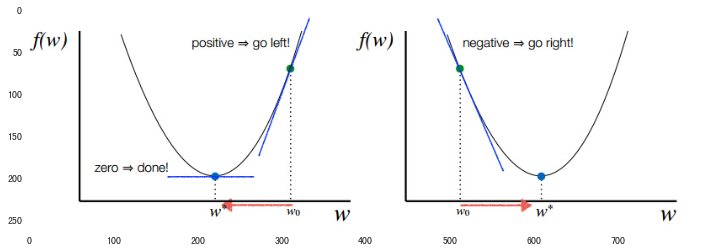

In [2]:
show_image("./res/gradient_descent.jpg", figsize=(12,8))

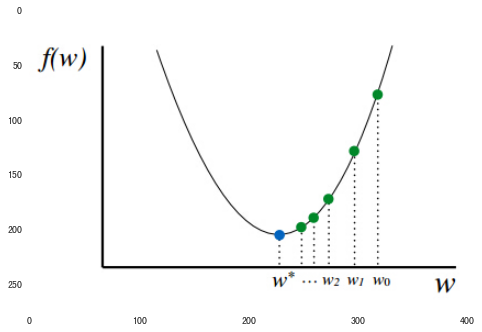

In [3]:
show_image("./res/iterator.jpg")

#### 2.1 增量寻优

梯度下降法是利用了导数做为步进参考值，它要求函数是已知且可导的。问题是，现实中，有时这个函数是未知的，比如说对应的是一台机器。我不知道怎么对它建模，唯一的信息就是喂它输入，它就会返回输出。那怎么办呢？

首先，我们回到 $\frac{\partial f(x)}{\partial x}$ 来看，因为步进大小还受 $\lambda$ 调控。这里梯度的作用，其实主要是指示步进方向。

然后，我们换个思路找步进方向。

假设机器的真实模型是 $f(x)$，对我们来说它是未知的。尝试如下：

+ 第一次试探，随机给个初始值 $x_0$，得到 $f(x_0)$。
+ 第二次试探，再随机输入 $x_1$，得到 $f(x_1)$。

这时，有如下三种情况，可以指导第三次试探：

1. $f(x_1) < f(x_0)$，也就是 $x_0 \to x_1$的方向是对的。
2. $f(x_1) = f(x_0)$，没有有用信息。
3. $f(x_1) > f(x_0)$，方向反了。

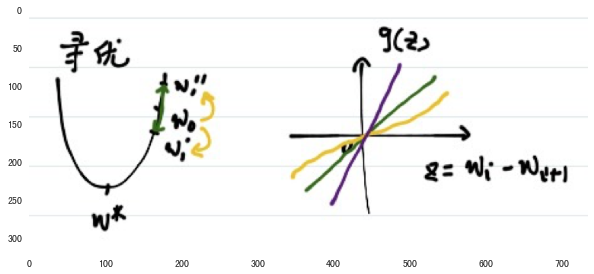

In [4]:
show_image("./res/incr_opt.png", figsize=(10,5))

因为我们始终是找极小值点，这个过程就始终如上图所示"U"形。那么每次的步进方向就可用 $f(x_1) - f(x_0)$ 来指示。也就是说，虽然我们无法对机器$f(x)$建模，但我们可以对寻优的过程 $z = f(x_i) - f(x_{i+1})$ 建模 $g(z)$。而 $g(z)$ 只要满足单调且过零点，理论上它可以是任意的，不同函数影响的只是收敛速度，但都会收敛到 $w^*$ 附近。

#### 2.2 逼近

再换个角度，我们不再想寻优。而是假设这个极小值$w^*$已经知道了，如何从初始值$w_0 = f(x_0)$一步步逼进到这个极小值$w^*$。其实可以完全借用上节的增量寻优建模手法，我们定义 $z = f(x_i) - w^*$，从而对逼近过程建模 $g(z)$。

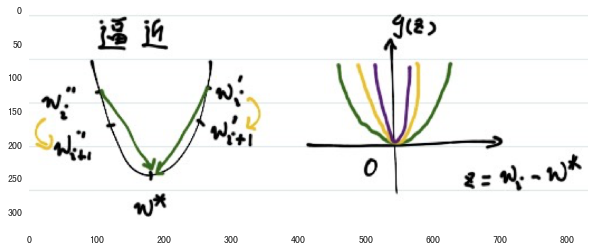

In [5]:
show_image("./res/approx.png", figsize=(10,5))

同样地，$g(z)$只要满足一定条件的函数。在这里，就是过零点，正数区间单增，负数区间单减，最常见的代表就是二次函数 $g(z) = z^2$。

我们梳理下整个逼近过程，如下图：

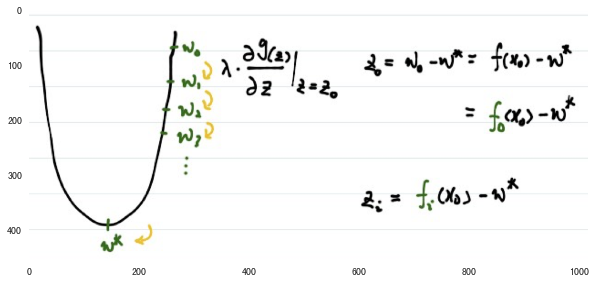

In [6]:
show_image("./res/model.png", figsize=(10,5))

从初始点$w_0$，沿着$w_1, w_2, \dotsc, w_i$到达$w^*$。其中每步的步长是$\lambda \frac{\partial g(z)}{\partial z} |_{z = z_i}$。$\lambda$是控制步长的字习率，不用管。我们重点看下$z_i$:

\begin{align}
    z_i &= w_i - w^* \\
        &= f(x_i) - w^*
\end{align}

上面，每一步对应的$f(x_i)$是一个恒定的模型，变动的是$x$。我们反着想，假设$x$是固定的，而这个模型其实是变化的 $f_i(x)$，再把$w^*$用$y$表示。那么 

\begin{align}
    z_i &= f(x_i) - w^* \\
        &= f_i(x) - y
\end{align}

是不是开始有点眼熟了，如果我们再令 $g(z) = z^2$，展开看看：

\begin{align}
    g(z_i) &= z_i^2 \\
           &= (y - f_i(x))^2
\end{align}

好了，我们总结下上述函数的意义：     
给定自变量$x$、目标值$y$和初始位置$w_0$，可以用规定的$g(z)$和模型$f_i(x)$来构建出一个迭代序列$\{w_0, w_1, \dotsc, y\}$，其中$w_{i+1} = w_i - \lambda \frac{\partial g(z)}{\partial z} \, |_{z = y - f_i(x)}$。

而：    
+ 对给定$x$，$y$是常数，所以$\partial z = \partial f_i(x)$。
+ $g(z) | z = y - f_i(x)$表述的是$y$和$f_i(x)$的距离相近度，可以更泛性推广记为$L(y, f_i(x))$。

所以记$w_{i+1} = w_i - \lambda \frac{\partial L(y, f_i(x))}{\partial f_i(x)}$

用机器学习的术语翻译就是，如果有特征$x$、目标值$y$和初始模型$f_0$，对某个损失函数$L(y, f_i(x))$，就有模型序列使得$f_i(x) \to y$。

而Gradient Boosting就是回答了上述的两个规定：

1. 怎样构建模型序列$f_i$?
2. 什么样的损失函数$L(y, f_i(x))$?

### 3. Gradient Boosting

#### 3.1 怎样构建模型序列$f_i$
Gradient Boosting的答案就是使用Boosting来训练Gradient(梯度）值的加法模型。

具体来说，已知有特征$x$、标签$y$和初始模型$f_0$。   
然后，我们选定一种机器学习算法$\text{Model}(\text{feature}, \text{value})$，输入数据后就会给出模型$F(x)$。

我们规定模型生成序列方法如下：

\begin{align}
    & F_0 = f_0 \\
    & \hat{y_i} = - \frac{\partial L(y, f_{i-1}(x)}{\partial f_{i-1}(x)} \\
    & F_i = \text{Model}(x, \hat{y_i}) \\
    & f_{i} = f_{i-1} + F_i  = \displaystyle \sum_{k=0}^{i} F_k \\
\end{align}

上式第二行就是Gradient（梯度），第三行就是用梯度训练的单个模型$F_i$，而第四行$f_i$就是Boosting加法。请注意区分$f_i$和$F_i$。

很多时候，我们期望初始模型自动产生，并且和其它模型是同种类型的，上面的生成序列方法就可改写为：

\begin{align}
    & F_0 = \text{Model}(x, y) \\
    & \hat{y_i} = - \frac{\partial L(y, f_{i-1}(x)}{\partial f_{i-1}(x)} \\
    & F_i = \text{Model}(x, \hat{y_i}) \\
    & f_{i} = f_{i-1} + F_i  = \displaystyle \sum_{k=0}^{i} F_k \\
\end{align}

总结下流程：

1. 用$x$和$y$训练初始模型$F_0$，并令累加模型$f_0 = F_0$。
2. 用梯度计算出残差 $\hat{y_i}$。
3. 用$x$和残差训练新模型$F_i$。
4. 将新模型加入累加模型$f_i$。
5. 迭代直到达到终止条件。

#### 3.2 什么样的损失函数 $L(y, f_i(x))$

正如2.2节所说，损失函数$L(y, f_i(x))$定义的是从初始值到目标值的逼近过程。常理来说，离得越远，我们期望步距越大，调整越剧烈；离得越近，期望步距越小，调整越缓合。常用的有L1, L2和logistic。当然，理论上，你也可以用其它千奇百怪的函数，只要它符合$x_1 \to x_2 \implies f(x_1) \to f(x_2)$。

### 4. GBDT(Gradient Boosting Decision Tree)

将第3节中的机器模型Model换成决策树，就得到了GBDT。嗯，就是这么简单。

Treeboost是具体对决策树参与的计算做了公式推导，作用是简化运算量，打算后续开文专门讲。

### 总结
我们最后总结下，GBDT是Gradient Boosting框架用决策树完成的一个具体实现。Gradeint Boosting框架的本质思路是一个从基准值到目标值的逼近过程，也是一个基准弱模型向强模型的进化过程。逼近过程是用损失函数来描述和控制的，具体的步进量（残差）由损失函数的梯度来指示。机器模型的作用是用来拟合和预测残差。

所以，我以前不理解决策树怎么求导，而事实是决策树压根就和求导没关系。希望这篇文章能帮助到其它人的理解，也请指正错点漏点疑点。